# Training and Test


### 1. Start the Environment

The next cell starts the Unity environment. Please do not forget to download the environment first and set the `file_name` argument accordingly.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from unityagents import UnityEnvironment
from collections import deque
from agent import DDQN_Agent
import torch
import matplotlib.pyplot as plt
import pandas as pd 

# please fill in your path to the Banana environment
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe", worker_id=1, seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.27946243 0.
 1.         0.         0.         0.74556106 0.         0.
 1.         0.         0.48277503 0.         1.         0.
 0.         0.30341193 0.         0.         1.         0.
 0.46494457 0.         0.         1.         0.         0.08466676
 0.         1.         0.         0.         0.95967758 0.
 0.        ]
States have length: 37


### 3. Train the Agent

In [4]:


agent = DDQN_Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size, tau=.1)

def train(n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            state = env_info.vector_observations[0] 
            action = int(agent.act(state, eps))
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

train_scores = train()

Episode 100	Average Score: 0.90
Episode 200	Average Score: 4.56
Episode 300	Average Score: 6.30
Episode 400	Average Score: 7.63
Episode 500	Average Score: 9.23
Episode 600	Average Score: 10.81
Episode 700	Average Score: 11.47
Episode 800	Average Score: 11.73
Episode 900	Average Score: 12.73
Episode 1000	Average Score: 13.86
Episode 1100	Average Score: 13.64
Episode 1200	Average Score: 13.35
Episode 1300	Average Score: 13.88
Episode 1400	Average Score: 14.60
Episode 1500	Average Score: 14.63


#### Plot Learning Curve

In [11]:
data = pd.DataFrame({'score': train_scores})
data.to_csv('scores.csv', sep='\t', index=False,header=True)


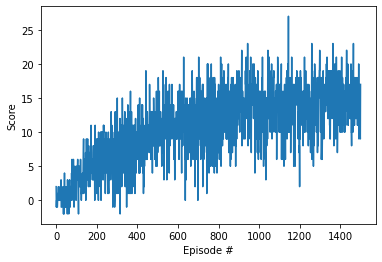

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(train_scores)), train_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("learning-curve.png")
plt.show()


### 4. Test the Agent

The agent solves the environment if the score is larger than $13$.

In [4]:
agent = DDQN_Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

scores = []

for i_episode in range(1, 101):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    for t in range(1000):
        state = env_info.vector_observations[0] 
        action = int(agent.act(state, 0))
        
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
            
        state = next_state
        score += reward
        if done:
            break 
    scores.append(score)       # save most recent score
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")

Episode 100	Average Score: 16.04

When finished, we close the environment.

In [6]:
env.close()